In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as k
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)


In [2]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [3]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [4]:
p10049.dtypes

UserID               float64
Systolic             float64
Diastolic            float64
Heart Rate           float64
DOB           datetime64[ns]
Weight               float64
Height               float64
Gender                object
dtype: object

In [5]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [6]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=5)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=5)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


KNN Inputation

In [7]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [9]:
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
df = df_time_imputed

In [11]:
df_train = df[:-24]
df_test  = df[-24:]

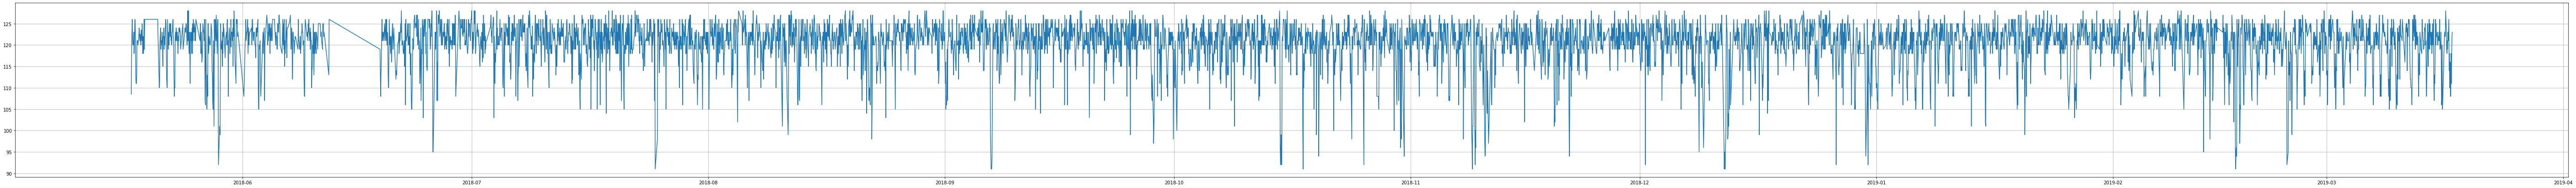

In [17]:
plt.figure(figsize=(100,7))
plt.grid()
plt.plot(df_train.Systolic)
plt.title('')
plt.show()

In [19]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(df_train.Systolic, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -32.154055
P-Value                    0.000000
# Lags Used                3.000000
# Observations Used     7294.000000
Critical Value (1%)       -3.431247
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


Text(0.5, 1.0, 'Systolic differencing')

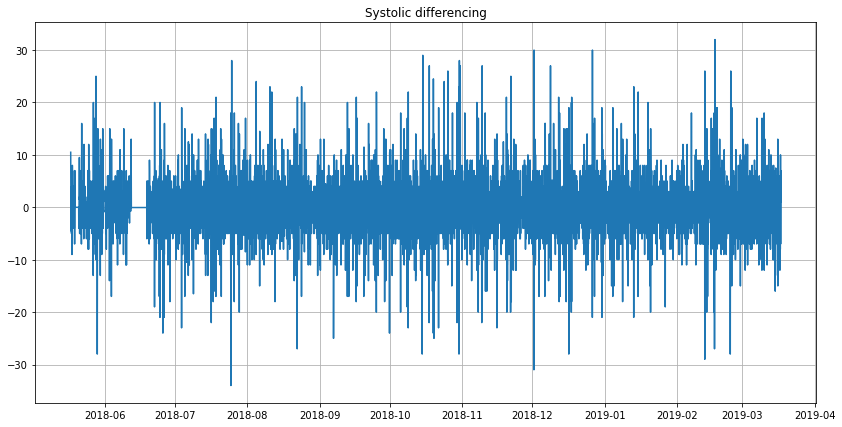

In [22]:
# trend differencing
df_diff_train = df_train.Systolic.diff(1)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(df_diff_train)
plt.title('Systolic differencing')

Text(0.5, 1.0, 'Systolic seasonal differencing')

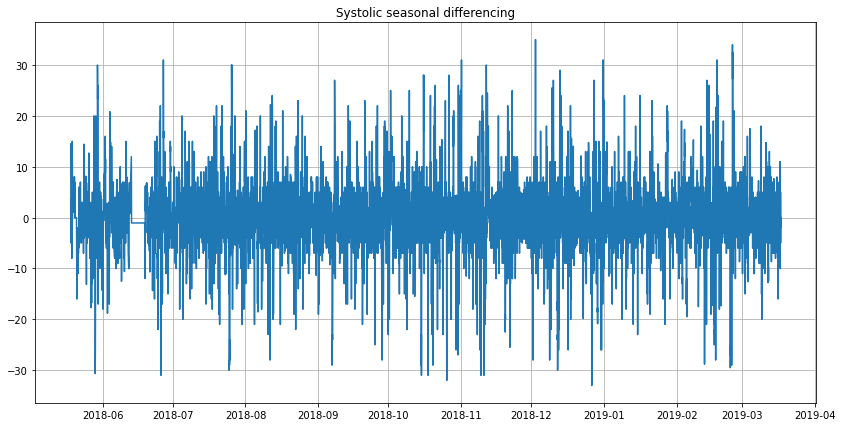

In [21]:
# seasonal differencing
df_season_diff_train = df_train.Systolic.diff(24)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(df_season_diff_train)
plt.title('Systolic seasonal differencing')

In [23]:
print_adf_result(adfuller(df_season_diff_train.dropna()))


Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.861533e+01
P-Value                 2.063455e-30
# Lags Used             3.000000e+01
# Observations Used     7.243000e+03
Critical Value (1%)    -3.431253e+00
Critical Value (5%)    -2.861939e+00
Critical Value (10%)   -2.566982e+00
dtype: float64


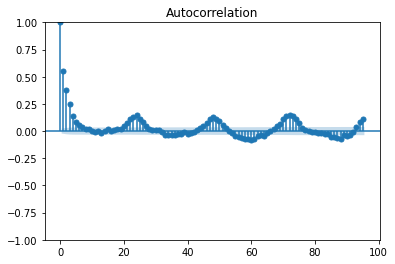

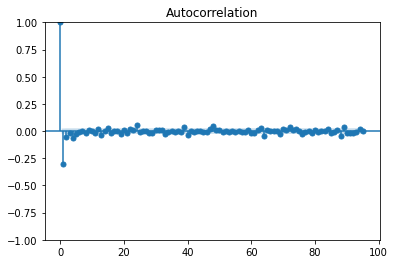

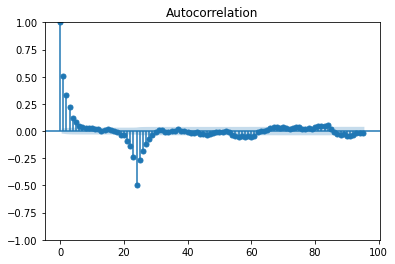

In [41]:
# plot ACF plot
# plot ACF plot

plot_acf(df_train.Systolic.dropna(), lags=range(0,96));
plot_acf(df_diff_train.dropna(), lags=range(0,96));
plot_acf(df_season_diff_train.dropna(), lags=range(0,96));

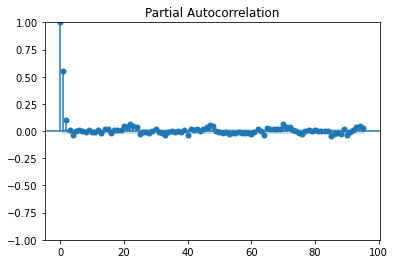

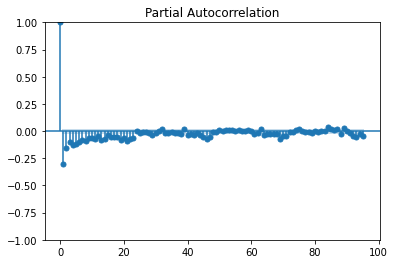

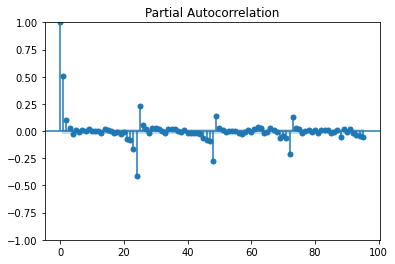

In [42]:
plot_pacf(df_train.Systolic.dropna(), lags=range(0,96));
plot_pacf(df_diff_train.dropna(), lags=range(0,96));
plot_pacf(df_season_diff_train.dropna(), lags=range(0,96));


In [37]:
from statsmodels.tsa.arima.model import ARIMA

arima_000 = ARIMA(df_season_diff_train.dropna(), order=(0,0,0)).fit()
arima_000.summary()

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Systolic   No. Observations:                 7274
Model:                          ARIMA   Log Likelihood              -24598.590
Date:                Wed, 17 Aug 2022   AIC                          49201.180
Time:                        22:40:37   BIC                          49214.964
Sample:                    05-18-2018   HQIC                         49205.920
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.083     -0.012      0.990      -0.165       0.163
sigma2        50.6818      0.495    102.410      0.000      49.712      51.652
===================================================================================
Ljung-Box (L1) (Q):                1849.12   Jarque-Bera (JB):              4306.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""